# Text analysis of rallypoint posts
Daniel M. Low



In [1]:
# !pip install -q -U pip setuptools wheel
# !pip install -U importlib-metadata #required for flair
# !pip install -q flair #needs Python=3.8
# !pip install -q umap-learn #needs Python=3.8
# !pip install -q sentence-transformers
# !pip install -q -U kaleido
# !pip install -q keybert==0.5.1
# !pip install -q -U spacy

In [2]:
# !python -m spacy download en_core_web_sm

In [3]:
# the restart the jupyter kernel

In [4]:
import os
import datetime
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import kaleido
from collections import Counter
import plotly.io as pio
import re
import flair
import spacy
from keybert import KeyBERT
from collections import Counter
import umap
from sklearn.metrics.pairwise import cosine_similarity

pio.orca.config.use_xvfb = True

/Users/danielmlow/miniconda3/envs/rallypoint_suicide_detection/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
on_google_drive = False

if on_google_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    input_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/input/'
    output_dir = '/content/drive/MyDrive/datum/rallypoint_suicide_detection/data/output/'
else:
    input_dir = './data/input/'
    output_dir = './data/output/'
    

In [6]:
# config
data_path = input_dir+'rp/' #comes from: Noah's Dropbox "RallyPoint Milestone 6 Code/Model notebook/multimodal_toolkit/datasets/rp/"
ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

# Functions

In [7]:
def vectorize(docs, list_of_lists = False, embedding_type = 'sentence', model_name = 'default'):
  '''
  Args:
    docs: list (each element is a string for an entire document) or list of lists (each inner list represents a
    documents and contains tokens (words, clauses, sentences)). See list_of_lists argument below.

    list_of_lists : bool, default=False
      if False, function expects a list of strings.
        [ 'happy', 'table', ... ]

      if True, function expects a list of list of strings
        [   ['I', 'thought', ...],
          ['By', 'the', ...],
          ...
        ]
        or
        [   ['I went to the movies', 'I hated it', ...],
          ['By the time she arrived I had already left', 'cannot stand shouting', ...],
          ...
        ]

    embedding_type : {'transformer_word', 'document'}, default='sentence'
      Only applicable if package == 'flair'
      Embeddings can be created for words, sentences, and documents.
      word : traditional word embeddings (glove, word2vec)

    model_name : {'default' or see under each package type for URLs to list of model names},
      default for
      default for ='all-MiniLM-L6-v2'

  Returns:
    array of embeddings

  '''

  from flair.data import Sentence
  # todo file_download.py:624: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  #   FutureWarning,
  if embedding_type == 'transformer_word':
    # Transformer word embeddings
    # ====================================
    # documentation: https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/TRANSFORMER_EMBEDDINGS.md
    # models: https://huggingface.co/transformers/v2.3.0/pretrained_models.html
    from flair.embeddings import TransformerWordEmbeddings
    embedder = TransformerWordEmbeddings(model_name)# init embedding
  elif embedding_type == 'sentence':
    # same as using sentence_transformers, but more decimals (sentence_transformers rounds to 8)
    # Embeddings from sBERT
    # https://www.sbert.net/docs/pretrained_models.html
    # https://docs.google.com/spreadsheets/d/14QplCdTCDwEmTqrn1LH4yrbKvdogK4oQvYO1K1aPR5M/edit#gid=0
    # https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_5_DOCUMENT_EMBEDDINGS.md#sentencetransformerdocumentembeddings
    from flair.embeddings import SentenceTransformerDocumentEmbeddings
    embedder = SentenceTransformerDocumentEmbeddings(model_name)
  if 'word' in embedding_type:
    # docs = ['happy', 'sad']
    print(f'encoding {embedding_type} model: {model_name}')
    # doc.tokens will take the tokens you give or split into words by default and returns list of list either way
    flair_docs = [embedder.embed(Sentence(doc))[0] for doc in docs]
    embeddings = np.array([np.array([token.embedding.cpu().detach().numpy() for token in doc.tokens], dtype=object)
                            for doc in flair_docs], dtype=object)
    print('docs:', embeddings.shape)
    # print('tokens x embedding size:', [n.shape for n in embeddings])
    return embeddings
  else:
    print(f'encoding {embedding_type} model: {model_name}')

    if list_of_lists:
      '''
      docs = [['i am happy', 'not today'], ['i went to the movies', 'i like popcorn', 'how about you']]
      '''
      # from datetime import datetime
      # start=datetime.now()
      embeddings = []
      for doc in docs:
        flair_tokens = [embedder.embed(Sentence(token))[0] for token in doc]
        docs_embeddings = np.array([flair_token.embedding.cpu().detach().numpy() for flair_token in flair_tokens], dtype=object)
        embeddings.append(docs_embeddings)
      embeddings = np.array(embeddings, dtype=object)
      # print('tokens x embedding size:', [n.shape for n in embeddings])
      # print(datetime.now()-start)
    else:
      if type(docs)==str:
        embeddings = np.array([embedder.embed(Sentence(docs))[0].embedding.cpu().detach().numpy()], dtype=object)
      else:
        # docs = ['i am a boy', 'you are a boy']
        # Warning: I had previously wrapped each embedding in an additional list: resulting in shape (len_of_docs,1,384). removed so I can compute similarity with single words (1,384)
        embeddings = np.array([embedder.embed(Sentence(doc))[0].embedding.cpu().detach().numpy() for doc in docs], dtype=object)

    print('docs x embedding size:', embeddings.shape)
    return embeddings


In [24]:


def merge_counts_by_similarity(counts, most_similar_df, cutoff = 0.8, do_not_merge= None,display_word='shortest',display_word_exceptions=None, returned_merged_themes = False, verbose = False):
    '''
    counts: dict {word1: 12,  word2: 144, ...}
    most_similar_df: DF with cols: [word1, word2, cosine similarity] with col names: ["theme_a", "theme_b", "cos"]
    cutoff: this decimal [0,1] represents cosine similarity >= cutoff everything will be merged
    do_not_merge: list 
    display_word: final display word, only implemented shorted. could be most frequent.  # ('suicidal', 'suicide') > 'suicide' because tends to be most simplest form
    display_word_exceptions: list  # show this if available
    '''
    themes_to_merge_df = most_similar_df[most_similar_df['cos']>=cutoff]
    counts_merged = {}
    
    for key_theme,value in counts.items():
        if verbose:
            print('theme:', key_theme)
        themes_to_merge_i = themes_to_merge_df[(themes_to_merge_df['theme_a']==key_theme) | (themes_to_merge_df['theme_b']==key_theme) ]
        if themes_to_merge_i.shape[0]==0:
            # print(theme, 'not found in similarity_df (does not have highly similar match. skipping.')
            counts_merged[key_theme] = value 
            continue
        if verbose:
            display(themes_to_merge_i)
        themes_to_merge = np.unique(themes_to_merge_i[['theme_a', 'theme_b']].values.flatten())
        themes_to_merge = [n for n in themes_to_merge if n in counts.keys()] #only if in this specific counts dict, there are more themes in similarity df

        if do_not_merge:

            # this will remove mentions of other branches but keep mentions of the same branch
            # =================================================================================
            to_remove = []
            do_not_merge_copy = do_not_merge.copy()
            do_not_merge_d = {}
            do_not_merge_d_counts = {}
            for do_not_merge_i in do_not_merge:
                do_not_merge_d[do_not_merge_i]=[]
                do_not_merge_d_counts[do_not_merge_i]=0
            for t in themes_to_merge:
                for n in do_not_merge:
                    # do_not_merge_copy.remove(n)
                    if n in t: # if 'army' in 'army reserve' or : 'army' 'navy'
                        do_not_merge_d[n].append(t)
                        do_not_merge_d_counts[n]+=1
            do_not_merge_d_counts = pd.DataFrame(do_not_merge_d_counts, index=['count']).T
            do_not_merge_d_counts = do_not_merge_d_counts[do_not_merge_d_counts['count']>0]            
            if do_not_merge_d_counts.shape[0]>=2:
                choose_one_set = max(do_not_merge_d_counts.to_dict().get('count'), key=do_not_merge_d_counts.to_dict().get('count').get)
                other_sets = [n for n in do_not_merge if n!=choose_one_set]
                to_remove = [do_not_merge_d.get(n) for n in other_sets]
                to_remove = [n for i in to_remove for n in i]
            # =================================================================================   
            themes_to_merge = [n for n in themes_to_merge if n not in to_remove]
            if len(themes_to_merge) == 0:
                counts_merged[key_theme] = value 
                continue
                
                    
        if verbose:    
            print(themes_to_merge)

        if display_word == 'shortest': # other options have not been implemented
            shortest_word = min((word for word in themes_to_merge if word), key=len)

        if display_word_exceptions:
            for word in display_word_exceptions:
                if word in themes_to_merge:
                    shortest_word = word
        sum_themes_to_merge = np.sum([counts.get(word) for word in themes_to_merge])

        if verbose:    
            print(shortest_word)
            print('counts per word:', [counts.get(word) for word in themes_to_merge])
        
        
        if returned_merged_themes:
            counts_merged[shortest_word] = [sum_themes_to_merge, themes_to_merge]
        else:
            counts_merged[shortest_word] = sum_themes_to_merge
            
        
        if verbose:    
            print('sum:', counts_merged[shortest_word])


    return counts_merged


# Load data or preprocess data

In [8]:
load = True

if load:
  df = pd.read_csv(input_dir+'dataset_wo_augmented.csv', index_col = 0)

else:


  #load data and drop duplicates

  train = pd.read_csv(data_path + 'train.csv')
  train = train.drop_duplicates(subset='content') #drop duplicates
  display(train.head())
  display(train['dataset'].value_counts())
  test = pd.read_csv(data_path + 'test.csv')
  test = test.drop_duplicates(subset='content')
  test.label = test.label.astype('int8')
  display(test['dataset'].value_counts().index.tolist())
  # val 
  val = pd.read_csv(data_path + 'val.csv')
  val = val.drop_duplicates(subset='content')
  display(val['dataset'].value_counts())

  print(train.shape)
  print(val.shape)
  print(test.shape)

  train['split'] = ['train']*train.shape[0]
  val['split'] = ['val']*val.shape[0]
  test['split'] = ['test']*test.shape[0]

  #concat
  df = pd.concat([train, val, test])
  df = df.reset_index(drop=True)

  #save
  df.to_csv(input_dir+'dataset_with_augmented.csv')

  # there are augmented artificial samples that we'll want to remove to only analyze real posts
  nonaugmented_datasets = test['dataset'].value_counts().index.tolist()
  # keep only nonaugmented datasets
  print(train.shape)
  df = df[df['dataset'].isin(nonaugmented_datasets)]
  df.to_csv(input_dir+'dataset_wo_augmented.csv')

# set aside SITB_absent to code as either related to mental health or nonrelated

In [10]:
df_absent = df[df['label']==0]
tag_sets = [np.array(eval(tag_set)).flatten().tolist() for tag_set in df_absent['tags'].values] #from string to lists
tag_sets_all = [n for i in tag_sets for n in i]
# Counter(tag_sets_all)[:10]

# Extract keywords from content

Each post can have author-generated tags, but they don't always, so I generated new keywords from the posts to merge with the tags.

In [13]:

def spacy_lemmatizer(docs, language = 'en'):
	# docs = ['recovery limbo anyone else recovered still unhealthy relationship foodbody basically eating maintenance past 6 years period quite severe anorexia 14ish still feel like barely changed still feel proud skip meal feel bad body etc anyone else similar boat feels like better long time guess',
	#         'food worst drug hey guys fat fatty fat thinking sucks quit food eat like dopamine stop quit smoking drinking weed heroin meth food sucks relationship food sucks hate sucks thanks coming rant wanted chest',
	#         'focus anything bring eat guess going fail finals one freshman fuck ups taken gap year feel consumed pain crippling falling knees type']
	# todo my_module = importlib.import_module("spacy.lang."+language) # from spacy.lang.en import English

	if language=='en':
		nlp = spacy.load('en_core_web_sm', disable = ['parser','ner'])

	# 	todo: make available for other languages but add: disable = ['parser','ner']
	# my_module = importlib.import_module("spacy.lang."+language) # from spacy.lang.en import English
	# if language=='en':
	# 	nlp = my_module.English()

	docs_lemmatized = []
	for doc in docs:
		doc = nlp(doc)
		doc_lemmatized = [token.lemma_ for token in doc]
		docs_lemmatized.append(doc_lemmatized)
	return docs_lemmatized


In [14]:
import string
import re

def remove_puctuation(doc):
	doc = doc.translate(str.maketrans('', '',string.punctuation))
	return doc


def remove_multiple_spaces(doc):
	return re.sub(' +', ' ', doc)


In [15]:
def remove_stopwords_doc(word_list,sws=None,extend_stopwords=None):
	if extend_stopwords:
		sws.extend(extend_stopwords)


	filtered_words = [word for word in word_list if word not in sws]
	filtered_words = ' '.join(filtered_words)

	return filtered_words

### Preprocessing + keyword extraction
- lemmatize and remove stopwords and punctuation
- After inspecting results using different methods (KeyBert and Yake), max ngram size (1 to 3 words), and top N words to return, we decided KeyBert, unigrams, and top 9 words if doc > 50. 

In [17]:
%%time

run_this = False

if run_this:

    verbose = True    
    kw_model = KeyBERT(model='all-MiniLM-L6-v2')
    docs = df.content.values

    # 4+ min

    docs_lemmatized = spacy_lemmatizer(docs)
    docs_lemmatized_joined = [remove_multiple_spaces(' '.join(doc).strip()) for doc in docs_lemmatized]

    # remove stopwords from docs
    # ==================================================================    
    docs_lemmatized_wo_sw = remove(docs_lemmatized_joined, extend_stopwords=['like', 'none','lot', 'go'])
    df['lemmatized'] = docs_lemmatized_joined
    df['lemmatized_wo_stopwords'] = docs_lemmatized_wo_sw
    df.to_csv(input_dir+'dataset_preprocessed.csv')
    
    # Obtain very extensive stopword list:
    # https://github.com/igorbrigadir/stopwords/blob/master/en/alir3z4.txt
    # added it locally
    with open(input_dir+'alir3z4_stopwords.txt', 'r') as f:
      stopwords = f.readlines()
    stopwords = [n.strip() for n in stopwords]

    # Keyword extraction
    # ==================================================================
    keywords_all = [] #set of keywords per doc


    print(f'{df.shape[0]} total docs.')
    for index, row in df.iterrows():
        if index%100==0:
          print(index)
        doc_raw = row['content']
        doc = row['lemmatized']
        doc_len = len(doc.split())
        if doc_len<=50:
          keywords_all.append([])
          # shorter documents often lacked clear themes and were generally responses to other posts
          continue
        for model in ['keybert']: #yake, not used here
          for ngram_range_max in [1]:#[1,2,3]:
            if model == 'keybert':
              if verbose and index%100==0:
                print(f'model: {model}      ngram_range_max: {ngram_range_max}')        
                print('='*80)
                print()
                print("doc from which we'll extract keywords:", doc_raw)
                print("doc word count: ", len(doc.split()))
              kw = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1,ngram_range_max), stop_words='english',
                                          #  highlight=True,
                                        top_n=10,
                                        # use_maxsum=False, nr_candidates=20, 
                                        # use_mmr=False, diversity=0.7
                                        )
              keywords = [k[0] for k in kw]
              keywords = remove_stopwords_doc(keywords, sws = stopwords)
              keywords = keywords.split()

              keywords_all.append(keywords)
              if verbose and index%100==0:
                print(keywords)


    print(df.shape)
    print(len(keywords_all))
    df['keybert_keywords'] = keywords_all
    df.to_csv(input_dir+'dataset_preprocessed_keywords.csv')




CPU times: user 223 ms, sys: 45.8 ms, total: 269 ms
Wall time: 314 ms


In [104]:
%%time 
kws_len = []

for kws in df.keybert_keywords.values:
  kws = eval(kws)
  kws_len.append(len(kws))

df['keywords_len'] = kws_len
kws_len_df = pd.DataFrame(Counter(kws_len), index = ['count']).T
kws_len_df = kws_len_df.reset_index()
kws_len_df.columns = ['len', 'count']
kws_len_df.sort_values('len')[::-1]

,len,count
3,10,1949
2,9,970
4,8,398
6,7,132
7,6,48
5,5,16
1,4,5
0,0,2903


# first, lets encode all tag words to see which embeddings are best


In [22]:
%%time
docs_lemmatized = spacy_lemmatizer(docs)
docs_lemmatized_joined = [remove_multiple_spaces(' '.join(doc).strip()) for doc in docs_lemmatized]

KeyboardInterrupt: 

In [118]:
%%time 

# df['tags_lemmatized'] = []

tag_sets = [np.array(eval(tag_set)).flatten().tolist() for tag_set in df['tags'].values] #from string to lists
tags_sets_wo_spaces = []
for tag_set in tag_sets:
  tag_set = [n.replace(' ','_') for n in tag_set]
  tag_set = ' '.join(tag_set)
  tags_sets_wo_spaces.append(tag_set)


tags_lemmatized = spacy_lemmatizer(tags_sets_wo_spaces)
df['tags_lemmatized'] = tags_lemmatized
df.to_csv(input_dir+'dataset_preprocessed_keywords.csv')

CPU times: user 16.7 s, sys: 104 ms, total: 16.9 s
Wall time: 17.1 s


### Encode 

bert-base-uncased ['Donald Trump', 'Trump', 'donald_trump', 'president', 'Bill Clinton']
bert-base-uncased


Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


encoding sentence model: bert-base-uncased
docs x embedding size: (5, 768)


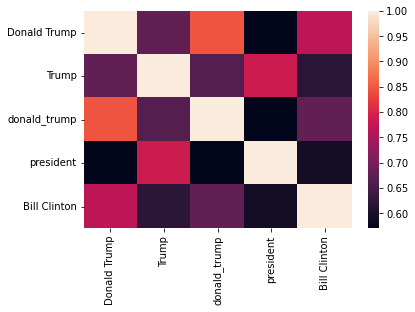

bert-base-uncased ['veterans', 'veterans_affairs', 'veterans affairs', 'va', 'VA', 'alzheimer s association', 'mental_health', 'mental health', 'dogs']
bert-base-uncased


Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


encoding sentence model: bert-base-uncased
docs x embedding size: (9, 768)


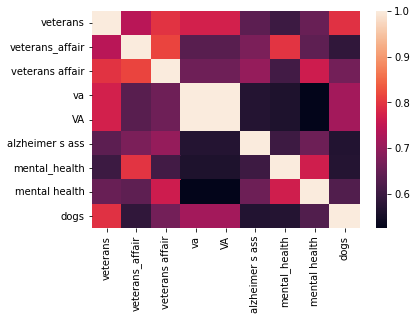

all-MiniLM-L6-v2 ['Donald Trump', 'Trump', 'donald_trump', 'president', 'Bill Clinton']
all-MiniLM-L6-v2
encoding sentence model: all-MiniLM-L6-v2
docs x embedding size: (5, 384)


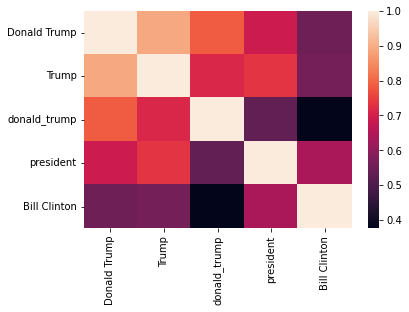

all-MiniLM-L6-v2 ['veterans', 'veterans_affairs', 'veterans affairs', 'va', 'VA', 'alzheimer s association', 'mental_health', 'mental health', 'dogs']
all-MiniLM-L6-v2
encoding sentence model: all-MiniLM-L6-v2
docs x embedding size: (9, 384)


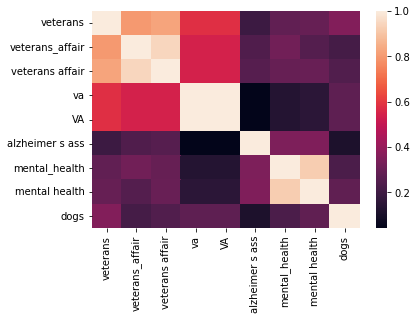

In [196]:
# Testing different embeddings 
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import seaborn as sns

docs1 = ['Donald Trump', 'Trump', 'donald_trump','president', 'Bill Clinton']
docs2 = ['veterans','veterans_affairs','veterans affairs', 'va', 'VA','alzheimer s association', 'mental_health', 'mental health', 'dogs']
model_name = 'bert-base-uncased'

for model_name in ['bert-base-uncased', 'all-MiniLM-L6-v2']:
  for docs in [docs1,docs2]:
    print(model_name, docs)
    print(model_name)
    embeddings = vectorize(docs, model_name = model_name, embedding_type = 'sentence')
    similarities = cosine_similarity(embeddings)
    hm = sns.heatmap(similarities,xticklabels=[n[:15] for n in docs], yticklabels=[n[:15] for n in docs])
    plt.show()



In [ ]:
df = pd.read_csv(input_dir+'dataset_preprocessed_keywords.csv',index_col = 0)

In [171]:
# hm = sns.heatmap(similarities,xticklabels=[n[:10] for n in docs], yticklabels=[n[:10] for n in docs])
# plt.show()

In [181]:
%%time
kws_all = [eval(n) for n in df['keybert_keywords'].values]
kws_all = [n for i in kws_all for n in i]
kws_all = [n.replace('_', ' ').strip() for n in kws_all]
kws_all = [re.sub("\d", "#", n) for n in kws_all]
kws_all = np.unique(kws_all)
print(kws_all[:30])
print(len(kws_all))

['# times sustainable' '##' '###' '####' '####s' '###k' '###st' '###th'
 '##a#' '##b' '##c' '##d' '##f' '##lbs' '##n' '##r' '##s' '##th' '#b' '#c'
 '#m' '#nd' '#r' '#sg' '#sgt' '#sgts' '#st' '#stsgt' '#th' '#yr']
6794


In [ ]:
# tags

tags_kws = []

tags_all = [eval(n) for n in df['tags_lemmatized'].values]
kws_all = [eval(n) for n in df['keybert_keywords'].values]
for tag,kw in zip(tags_all, kws_all):
    # print(tag)
    # print(kw)
    tag_kw_i = list(set(tag).union(set(kw)))
    tags_kws.append(tag_kw_i)
    # print(tag_kw_i)
    # print()

                    
df['tags_kws'] = tags_kws    



In [182]:
# tags
tags_all = [n for i in df['tags_lemmatized'].values.tolist() for n in i]
tags_all = [n.replace('_', ' ') for n in tags_all] # tags are encoded without "_" although returns similar results
tags_all = np.unique(tags_all)
print(tags_all[:30])
print(len(tags_all))

[' ' '#' '+' '142 fw' '143rd esc' '147th hrc' '15 mi'
 '153a flight physical' '193rd in bde' '1lt' '1sg' '1st amendment'
 '1stsgt' '2 7 cav' '2 years' '2014 statistics'
 '2016 presidential candidate' '21st ctc' '25d' '25th id' '2d lt' '2lt'
 '2nd amendment' '3' '355 fw' '377th tsc' '3rd mardiv' '4' '401' '401k']
2882


In [184]:
themes = list(set(tags_all).union(set(kws_all)))
len(themes)

8793

In [191]:
%%time
embeddings = vectorize(themes, model_name ='all-MiniLM-L6-v2', embedding_type = 'sentence')


encoding sentence model: all-MiniLM-L6-v2
docs x embedding size: (8793, 384)
CPU times: user 2min 29s, sys: 534 ms, total: 2min 30s
Wall time: 2min 33s


In [193]:
emb_cols = ['emb_'+str(n).zfill(3) for n in range(embeddings.shape[1])]
embeddings_df = pd.DataFrame(embeddings, columns = emb_cols)
embeddings_df['themes'] = themes
embeddings_df = embeddings_df[['themes']+emb_cols]
embeddings_df

,themes,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,...,emb_374,emb_375,emb_376,emb_377,emb_378,emb_379,emb_380,emb_381,emb_382,emb_383
0,desert,0.069197,0.043847,-0.036797,0.075181,0.005958,0.005078,0.119261,-0.092358,0.049004,...,0.076269,-0.027733,0.052217,-0.075329,-0.024074,0.086645,0.114244,-0.010427,-0.029352,-0.009511
1,sexual harassment assault response & prevention,-0.03356,0.159576,-0.005803,0.0304,0.054672,0.092713,-0.028152,-0.030945,-0.009913,...,-0.008026,-0.016373,0.056535,-0.046464,-0.028219,-0.005606,0.073084,-0.04892,0.051039,0.034319
2,surgeon,-0.061286,0.083368,0.007459,-0.004089,-0.12143,-0.106534,0.097803,0.03629,-0.001456,...,-0.033713,0.014606,0.08111,0.006161,-0.061869,0.079971,0.070778,-0.040116,0.070377,0.044107
3,isolated,-0.045947,-0.015624,-0.05758,0.052028,0.074154,0.005087,0.080171,0.002364,0.006391,...,0.109304,0.024892,-0.019952,0.013182,-0.080004,0.041905,0.034113,0.026023,-0.021594,0.026923
4,spend,0.03111,0.077166,-0.062509,0.019599,0.024958,0.007939,0.206832,0.00837,0.036329,...,-0.00311,0.00285,0.051352,0.036513,-0.020375,0.007688,0.111263,-0.066941,-0.002279,-0.019273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8788,medals,-0.073169,0.131161,0.009218,-0.000619,-0.062129,0.075856,0.138209,-0.017103,0.001416,...,-0.027427,0.044172,0.020145,-0.039961,0.0152,-0.003249,0.081968,-0.08702,-0.05993,0.015935
8789,resume,-0.090089,0.00874,-0.007578,0.041055,0.009253,0.073268,-0.039846,0.02808,-0.096537,...,-0.004505,-0.013217,0.027661,-0.04064,-0.069647,-0.038645,0.099261,-0.022267,-0.063209,0.022676
8790,buddhist,-0.018949,-0.01061,-0.061309,0.054034,-0.057801,0.001203,0.112447,-0.047009,0.11239,...,-0.027039,0.046368,-0.02144,0.058204,-0.077232,-0.039488,0.113526,0.045135,0.008411,0.057083
8791,testimony,-0.059181,0.114174,0.056745,0.015767,0.053098,0.008753,0.078643,-0.001687,0.074134,...,0.102577,0.045059,0.066138,0.036479,-0.050135,-0.054829,0.24072,0.093557,0.046683,-0.076937


In [194]:
embeddings_df.to_csv(input_dir+'themes_embeddings_df.csv')

# Synonymizer: Merge similar tags and keywords: compute cosine similarity between their embeddings. And merge almost all > 0.8

In [47]:
embeddings_df = pd.read_csv(input_dir+'themes_embeddings_df.csv', index_col = 0)

In [48]:
%%time
embedding_cols = [n for n in embeddings_df.columns if 'emb_' in n]
cosine_similarities  = cosine_similarity(embeddings_df[embedding_cols].values)
np.fill_diagonal(cosine_similarities, 0) #set diagonal to zero
cosine_similarities *= 1 - np.tri(*cosine_similarities.shape, k=-1) #set lower triangle to 0
cos_sim_df = pd.DataFrame(cosine_similarities, columns = embeddings_df['themes'].values, index = embeddings_df['themes'].values)
most_similar = cos_sim_df.stack()

CPU times: user 3.51 s, sys: 2.45 s, total: 5.96 s
Wall time: 3.38 s


### Warning this takes around 5-10m

In [49]:
%%time 
most_similar_nlargest = most_similar.nlargest(10000)

CPU times: user 13min 43s, sys: 32.1 s, total: 14min 15s
Wall time: 14min 38s


### Visually inspect a good cutoff value (depends on embedding model) and exceptions 

In [63]:
most_similar_df = most_similar_nlargest.reset_index()
most_similar_df.columns = ['theme_a', 'theme_b', 'cos']
most_similar_df = most_similar_df.round(2)
[list(n) for n in most_similar_df[(most_similar_df['cos']>=0.8) & (most_similar_df['cos']<0.9)].values] #make list so its prints everything

[['commands', 'command', 0.89],
 ['neurosurgeon', 'neurosurgery', 0.89],
 ['nationalists', 'nationalist', 0.89],
 ['international affair', 'foreign affair', 0.89],
 ['reclassification', 'reclasse', 0.89],
 ['flying', 'flight', 0.89],
 ['vain', 'vainly', 0.89],
 ['syrian', 'syria', 0.89],
 ['financial', 'finance', 0.89],
 ['korea', 'north korea', 0.89],
 ['louisiana state university', 'southeastern louisiana university', 0.89],
 ['women', 'womens', 0.89],
 ['assistants', 'assistant', 0.89],
 ['epileptic', 'epilepsy', 0.89],
 ['platoon commander', 'platoon sergeant', 0.89],
 ['posting', 'post', 0.89],
 ['proof', 'prove', 0.89],
 ['life lesson', 'life’s lesson', 0.89],
 ['vet', 'vets', 0.89],
 ['airline', 'airliner', 0.89],
 ['development', 'develop', 0.89],
 ['osama', 'osama bin laden', 0.89],
 ['vice president', 'office of the vice president', 0.89],
 ['nazi', 'nazis', 0.89],
 ['orthopedist', 'orthopedics', 0.89],
 ['confederate', 'confederacy', 0.89],
 ['locally', 'local', 0.89],
 ['tr

In [64]:
most_similar_df.to_csv(input_dir+'most_similar_df.csv')


In [94]:
# Distribution of tags
tags_clean = [n for i in df['tags_kws'].tolist() for n in i]
tags_clean = [n.replace('_', ' ') for n in tags_clean]
counts = Counter(tags_clean)
counts = dict(sorted(counts.items(), key=lambda item: item[1]))

pd.DataFrame(counts, index=['Count']).T[::-1]

,Count
ptsd,939
suicide,792
military,463
veteran,450
humor,421
...,...
pior,1
possiblity,1
asorbe,1
jumpmaster instructor,1


In [98]:
%%time
counts_merged = merge_counts_by_similarity(counts, 
                                        most_similar_df, 
                                        cutoff = 0.8, 
                                        do_not_merge= ['coast guard', 'marines', 'navy', 'army', 'air force',], # so that army is not merged with "air force".
                                        display_word='shortest',
                                        display_word_exceptions=['depression', 'air force', 'rallypoint', 'veterans'],    # show this if available
                                        returned_merged_themes = True,
                                        verbose = False)

CPU times: user 4.69 s, sys: 37.4 ms, total: 4.73 s
Wall time: 4.71 s


In [101]:
counts_merged_df = pd.DataFrame(counts_merged, index=['Count', 'Merged_from']).T.sort_values('Count')[::-1]
counts_merged_df

,Count,Merged_from
suicide,1029,"[suicidal, suicidality, suicide, suicides]"
ptsd,948,"[coping with ptsd, ptsd, ptsd claim, ptsd outb..."
army,877,"[army, military, military police, military ser..."
veterans,603,"[veteran, veteran care, veterans]"
military,505,"[armed service, military, military service]"
...,...,...
reflexology,1,1
smdd,1,1
confrontation,1,1
affiliate,1,1


array(['desert', 'sexual harassment assault response & prevention',
       'surgeon', ..., 'buddhist', 'testimony',
       'horses and horseback riding'], dtype=object)

In [112]:
%%time
mental_health_themes_embeddings = [embeddings_df[embeddings_df['themes']==n].drop('themes', axis=1).values for n in counts_merged_df.index.tolist()]
mental_health_embedding = vectorize(['mental health'], model_name ='all-MiniLM-L6-v2', embedding_type = 'sentence')

In [ ]:

def cosine_similarity_target(target_embeddings, embeddings):
	from scipy.spatial import distance

	distances = distance.cdist([target_embeddings], embeddings, "cosine")[0]
	min_index = np.argmin(distances)
	min_distance = distances[min_index]
	max_similarity = 1 - min_distance
	return distances, min_index, min_distance, max_similarity


In [195]:
# distances, min_index, min_distance, max_similarity = cosine_similarity_target(mental_health_themes_embeddings , mental_health_embedding)


In [133]:
from sentence_transformers.util import semantic_search
from sentence_transformers import util

In [134]:
def gen_semantic_search(corpus_embeddings, query_embeddings):

	# corpus_embeddings = corpus_embeddings.to('cuda')
	corpus_embeddings = util.normalize_embeddings(corpus_embeddings)

	# query_embeddings = query_embeddings.to('cuda')
	query_embeddings = util.normalize_embeddings(query_embeddings)
	hits = util.semantic_search(query_embeddings, corpus_embeddings, score_function=util.dot_score)
	return hits

# Add variable: about_mental_health

In [194]:
%%time
embedder = SentenceTransformer('all-MiniLM-L6-v2')
about_mental_health = []
query = 'mental health'
query_embedding = embedder.encode(query, convert_to_tensor=True)

for i,corpus in enumerate(df['tags_kws'].values):
    if i%500==0:
        print(i)
    if []==corpus:
        about_mental_health.append(0)
        continue
        
    corpus = [n.replace('_', ' ') for n in corpus]
    corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)

    # Find the closest n sentences of the corpus for each query sentence based on cosine similarity
    n=np.inf
    top_k = min(n, len(corpus))
    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]

    top_results = torch.topk(cos_scores, k=top_k)
    
    # for score, idx in zip(top_results[0], top_results[1])
    if any(t >=0.375 for t in top_results[0]):
        about_mental_health.append(1)
    else:
        about_mental_health.append(0)
            
df['about_mental_health'] = about_mental_health
df.to_csv(input_dir+'dataset_preprocessed_keywords_about_mental_health.csv')

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
CPU times: user 2min 57s, sys: 6.71 s, total: 3min 4s
Wall time: 2min 55s


In [147]:
"""
This is a simple application for sentence embeddings: semantic search

We have a corpus with various sentences. Then, for a given query sentence,
we want to find the most similar sentence in this corpus.

This script outputs for various queries the top 5 most similar sentences in the corpus.
"""
from sentence_transformers import SentenceTransformer, util
import torch

embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Corpus with example sentences

n=np.inf

queries = ['mental health']

corpus = counts_merged_df.index.tolist()[:100]

# queries = ['A man is eating pasta.', 'Someone in a gorilla costume is playing a set of drums.', 'A cheetah chases prey on across a field.']
# corpus = ['A man is eating food.',
#           'A man is eating a piece of bread.',
#           'The girl is carrying a baby.',
#           'A man is riding a horse.',
#           'A woman is playing violin.',
#           'Two men pushed carts through the woods.',
#           'A man is riding a white horse on an enclosed ground.',
#           'A monkey is playing drums.',
#           'A cheetah is running behind its prey.'
#           ]
corpus_embeddings = embedder.encode(corpus, convert_to_tensor=True)



# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = min(n, len(corpus))



for query in queries:
    query_embedding = embedder.encode(query, convert_to_tensor=True)

    # We use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)

    print("\n\n======================\n\n")
    print("Query:", query)
    print(f"\nTop {top_k} most similar sentences in corpus:")

    for score, idx in zip(top_results[0], top_results[1]):
        if score>=
        print(corpus[idx], "(Score: {:.4f})".format(score))

    """
    # Alternatively, we can also use util.semantic_search to perform cosine similarty + topk
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=5)
    hits = hits[0]      #Get the hits for the first query
    for hit in hits:
        print(corpus[hit['corpus_id']], "(Score: {:.4f})".format(hit['score']))
    """





Query: mental health

Top 100 most similar sentences in corpus:
mental health (Score: 1.0000)
psychiatric (Score: 0.7959)
depression (Score: 0.6908)
mental (Score: 0.6753)
health (Score: 0.6597)
psychology (Score: 0.5987)
therapy (Score: 0.5745)
anxiety (Score: 0.5617)
counseling (Score: 0.5178)
suicide (Score: 0.4966)
stress (Score: 0.4885)
ptsd (Score: 0.4884)
religion (Score: 0.4835)
drug (Score: 0.4541)
treatment (Score: 0.4287)
doctors (Score: 0.3977)
disability (Score: 0.3973)
med (Score: 0.3962)
war (Score: 0.3956)
trauma (Score: 0.3925)
life (Score: 0.3788)
doctor (Score: 0.3706)
care (Score: 0.3589)
death (Score: 0.3498)
military (Score: 0.3349)
humor (Score: 0.3338)
crime (Score: 0.3285)
retirement (Score: 0.3245)
vietnam (Score: 0.3242)
cops (Score: 0.3203)
family (Score: 0.3177)
sleep (Score: 0.3167)
talk (Score: 0.3161)
motivated (Score: 0.3074)
motivate (Score: 0.3063)
training (Score: 0.3045)
army (Score: 0.2983)
veterans (Score: 0.2924)
pain (Score: 0.2919)
suffer (

# Obtain words associated to both groups

In [35]:
df = pd.read_csv(input_dir+'dataset_preprocessed_keywords.csv', index_col = 0)
most_similar_df = pd.read_csv(input_dir+'most_similar_df.csv', index_col = 0)
embeddings_df = pd.read_csv(input_dir+'themes_embeddings_df.csv', index_col = 0)

In [36]:
df_present = df[df['label']==1] #suicidal
df_absent = df[df['label']==0] # controls

In [65]:
df_present

,id,hash,content,label,dataset,reputation,contact_size,type,ancestry,tags,type_tag_content,split,lemmatized,lemmatized_wo_stopwords,keybert_keywords,keywords_len,tags_lemmatized,tags_kws
10,5004096.0,d29a5b3658b33ffea934f10e8b7cd9e7,I had to talk someone out of killing herself a...,1.0,nock2000,0.000016,0.000196,0.0,3148987.0,"[""suicide"",""support""]",type| comment tag| suicide support body| I had...,train,I have to talk someone out of kill herself aft...,talk someone kill sexual assault rape someone ...,"['assault', 'rape', 'talk', 'conversation', 'c...",10,"['suicide', 'support']","['kill', 'assault', 'suicide', 'sexually', 'ta..."
18,2235189.0,7ebcce44bb0445046c3665ae42eee0f6,I have danced around that black abyss many tim...,1.0,nock2000,0.000672,0.000540,0.0,2234738.0,"[""mental health"",""ptsd""]",type| comment tag| mental health ptsd body| I ...,train,I have dance around that black abyss many time...,dance around black abyss many time make sense ...,"['depression', 'suicide', 'anxiety', 'abyss', ...",9,"['mental_health', 'ptsd']","['depression', 'abyss', 'suicide', 'straight',..."
23,175271.0,5031d416438fa9b292101a89f039c51f,I hear your battle cry and am here to help any...,1.0,Set 6,0.003617,0.006481,0.0,174272.0,[],type| comment tag| body| I hear your battle c...,train,I hear your battle cry and be here to help any...,hear battle cry help anyway mental health prof...,"['warning', 'sign', 'sadden', 'valley', 'menta...",8,[],"['deeply', 'recognize', 'mental', 'warning', '..."
70,388275.0,8feddc18ebc59ad43f459ab72b07f93f,Here is my take on the situation. I myself was...,1.0,nock2000,0.000042,0.001620,0.0,376421.0,"[""va claim"",""disability""]",type| comment tag| va claim disability body| H...,train,here be my take on the situation . I myself be...,take situation deploy 05 06 oif 08 09 oif last...,"['soldier', 'degenerative', 'sergeant', 'plato...",10,"['va_claim', 'disability']","['sergeant', 'army', 'degenerative', 'oif', 'd..."
128,681035.0,8302626a0ef3379915af747acfdfeba0,"Sir, , I apologize if my comment offended you...",1.0,nock2000,0.002325,0.009182,0.0,678243.0,"[""crime"",""law makers""]","type| comment tag| crime law makers body| Sir,...",train,"Sir , , I apologize if my comment offend you ....",sir apologize comment offend truth tell commen...,"['vet', 'offend', 'humor', 'suicide', 'apologi...",7,"['crime', 'law_maker']","['apologize', 'law_maker', 'vet', 'suicide', '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853,3888228.0,5a1820eed3230dccb1135b535db1684b,I survived PTSD because of team effort. A SSG...,1.0,nock2000,0.081236,0.024348,0.0,285003.0,"[""ptsd"",""suicide"",""stigma"",""command post""]",type| comment tag| ptsd suicide stigma command...,test,I survive PTSD because of team effort . a SSG ...,survive ptsd team effort ssg tell need help ho...,"['ptsd', 'therapist', 'recovery', 'suicide', '...",10,"['ptsd', 'suicide', 'stigma', 'command_post']","['survive', 'stigma', 'advice', 'therapist', '..."
6866,641006.0,7dabaeaeaaa225879a3b3c1ed53527e2,I am going through the same thing. My command ...,1.0,nock2000,0.000548,0.001873,0.0,639621.0,"[""ptsd"",""health""]",type| comment tag| ptsd health body| I am goin...,test,I be go through the same thing . my command an...,thing command soldier unit surprised admit sui...,"['ptsd', 'stigma', 'suicidal', 'psychologist',...",9,"['ptsd', 'health']","['stigma', 'treat', 'med', 'illness', 'health'..."
6870,4727138.0,3201d614d25df6b2a06499d355905b4b,I think it depends. If the person can actually...,1.0,nock2000,0.023590,0.032589,0.0,4686122.0,"[""veterans affairs"",""infantryman"",""combat engi...",type| comment tag| veterans affairs infantryma...,test,I think it depend . if the person can actually...,think depend person actually work entitlement ...,"['ptsd', 'veteran', 'disability', 'treatment',...",9,"['veterans_affair', 'infantryman', 'combat_eng...","['combat_engineer', 'taxpayer', 'treatment', '..."
6875,604006.0,5a1820eed3230

In [37]:
tags_col = 'tags_lemmatized'

tags_clean_all = {}
group_names = ['SITB Present', 'SITB Absent']
for df_i, name in zip([df_present, df_absent],group_names):

    tags_clean = []
    for tag_set in df_i[tags_col].values:
        # tag_set = np.array(eval(tag_set)).flatten() #for 'tags' col
        tag_set = [n.replace('_', ' ') for n in eval(tag_set)]
        tags_clean.extend(tag_set)

    tags_clean_all[name] = tags_clean

In [38]:
# kws
themes_clean_all = tags_clean_all.copy() #going to add to tags
group_names = ['SITB Present', 'SITB Absent']
for df_i, name in zip([df_present, df_absent],group_names):

    kws_clean = []
    for kw_set in df_i['keybert_keywords'].values:
        kw_set = np.array(eval(kw_set)).flatten() #for 'tags' col
        # tag_set = [n.replace('_', ' ') for n in tag_set]
        kws_clean.extend(kw_set)

    themes_clean_all[name].extend(kws_clean)
    themes_clean_all

In [46]:
# tags and kws

tags_kws_clean_all = {}
group_names = ['SITB Present', 'SITB Absent']
for df_i, name in zip([df_present, df_absent],group_names):

    tags_kws_clean = []
    for tag_kw_set in df_i['tags_kws'].values:
        tag_kw_set = np.array(eval(tag_kw_set)).flatten() #for 'tags' col
        tag_kw_set = [n.replace('_', ' ') for n in tag_kw_set]
        tags_kws_clean.extend(tag_kw_set)

    tags_kws_clean_all[name] = tags_kws_clean

### We'll use sentence embeddings given 42% of the tags have multiple words

In [49]:
# most_similar_df

# # merge config
# cutoff= 0.8 
# do_not_merge = ['coast guard', 'marines', 'navy', 'army', 'air force', 'military'] # so that army is not merged with "air force". 
# display_word = 'shortest' # ('suicidal', 'suicide') > 'suicide' because tends to be most simplest form
# display_word_exceptions = ['depression'] # show this if available


# # Merge
# themes_to_merge = most_similar_df[most_similar_df['cos']>=cutoff]
# # actual words used
# counts = Counter(tags_clean_i)
# counts = dict(sorted(counts.items(), key=lambda item: item[1]))
# for theme in counts.keys():
#     themes_to_merge_i = themes_to_merge[(themes_to_merge['theme_a']==theme) | (themes_to_merge['theme_b']==theme) ]
#     display(themes_to_merge_i)
#     break
#     # sum counts     
# # counts

,theme_a,theme_b,cos
0,june,september,0.65
96,vehicle,ford,0.65
97,trump,hillary clinton,0.65
98,dod civilian,servicemen,0.65
99,catholicism,secular,0.65
...,...,...,...
10004,vet,veterans,1.00
10005,guns,gun,1.00
10006,psychiatric,psychiatrist,1.00
10007,firearm,gun,1.00


In [68]:
tags_or_themes_d.keys()

dict_keys(['SITB Present', 'SITB Absent'])

# Fighting words approach to Bayesian odds ratio 

Monroe, B. L., Colaresi, M. P., & Quinn, K. M. (2008). Fightin'words: Lexical feature selection and evaluation for identifying the content of political conflict. Political Analysis, 16(4), 372-403.


https://convokit.cornell.edu/documentation/fightingwords.html#convokit.fighting_words.fightingWords.FightingWords.summarize

In [70]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer as CV
import string
exclude = set(string.punctuation)

def basic_sanitize(in_string):
    '''Returns a very roughly sanitized version of the input string.'''  
    in_string = ''.join([ch for ch in in_string if ch not in exclude])
    in_string = in_string.lower()
    in_string = ' '.join(in_string.split())
    return in_string

def bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = None, threshold_zscore=3, l1_name = 'Group 1', l2_name = 'Group 2'):
    '''
    Arguments:
    - l1, l2; a list of strings from each language sample
    - ngram; an int describing up to what n gram you want to consider (1 is unigrams,
    2 is bigrams + unigrams, etc). Ignored if a custom CountVectorizer is passed.
    - prior; either a float describing a uniform prior, or a vector describing a prior
    over vocabulary items. If you're using a predefined vocabulary, make sure to specify that
    when you make your CountVectorizer object.
    - cv; a sklearn.feature_extraction.text.CountVectorizer object, if desired.

    Returns:
    - A list of length |Vocab| where each entry is a (n-gram, zscore) tuple.'''

    prior = 0.1
    if cv is None and type(prior) is not float:
        print("If using a non-uniform prior:")
        print("Please also pass a count vectorizer with the vocabulary parameter set.")
        quit()
    l1 = [basic_sanitize(l) for l in l1]
    l2 = [basic_sanitize(l) for l in l2]
    if cv is None:
        cv = CV(decode_error = 'ignore', min_df = 10, max_df = .5, ngram_range=(1,ngram),
                binary = False,
                max_features = 15000)
    cv_fit = cv.fit_transform(l1+l2)
    counts_mat = cv_fit.toarray()
    # Now sum over languages...
    vocab_size = len(cv.vocabulary_)
    print("Vocab size is {}".format(vocab_size))
    if type(prior) is float:
        priors = np.array([prior for i in range(vocab_size)])
    else:
        priors = prior
    z_scores = np.empty(priors.shape[0])
    count_matrix = np.empty([2, vocab_size], dtype=np.float32)
    count_matrix[0, :] = np.sum(counts_mat[:len(l1), :], axis = 0)
    count_matrix[1, :] = np.sum(counts_mat[len(l1):, :], axis = 0)
    a0 = np.sum(priors)
    n1 = 1.*np.sum(count_matrix[0,:])
    n2 = 1.*np.sum(count_matrix[1,:])
    print("Comparing language...")
    for i in range(vocab_size):
        #compute delta
        term1 = np.log((count_matrix[0,i] + priors[i])/(n1 + a0 - count_matrix[0,i] - priors[i]))
        term2 = np.log((count_matrix[1,i] + priors[i])/(n2 + a0 - count_matrix[1,i] - priors[i]))        
        delta = term1 - term2
        #compute variance on delta
        var = 1./(count_matrix[0,i] + priors[i]) + 1./(count_matrix[1,i] + priors[i])
        #store final score
        z_scores[i] = delta/np.sqrt(var)
    index_to_term = {v:k for k,v in cv.vocabulary_.items()}
    sorted_indices = np.argsort(z_scores)
    return_list = []
    for i in sorted_indices:
        return_list.append((index_to_term[i], z_scores[i]))

    zscores = pd.DataFrame(return_list,columns = ['token', 'zscore'])
    feature_names = cv.get_feature_names_out()
    frequency_counts = cv_fit.toarray().sum(axis=0)
    freq = pd.DataFrame([feature_names, frequency_counts], index = ['token', 'count']).T
    zscores = zscores.merge(freq,on='token')
    
    zscores['label']= [l1_name if n >0 else l1_name for n in zscores['zscore'].values]

    annotation_names = []
    for token, boolean in zip(zscores['token'].values, pd.DataFrame(zscores['zscore'].abs()>=threshold_zscore).values):
      if boolean:
        annotation_names.append(token)
      else:
        annotation_names.append('')
    zscores['annotation_names']=annotation_names
    print("Comparing language: Done.")


    return zscores

    

In [212]:
%%time 

suicidal_tags = [' '.join(eval(n)).replace('_', '9999') for n in df_present['tags_kws'].values]
nonsuicidal_tags = [' '.join(eval(n)).replace('_', '9999') for n in df_absent['tags_kws'].values]


l1 = suicidal_tags
l2 = nonsuicidal_tags

l1_name = 'Suicidal'
l2_name = 'Non-suicidal'

ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')

# config
save_all_in_one = True
save_all_in_one_path = output_dir+f'odds_ratio_{ts}.html'  
figsize = [1200,800]
threshold = 1 #rating scale
threshold_zscore = 1.75 #abs value
# col = 'Daily_SI_Intent'
# df = df[df.SI_DescribeText!='nan'] #remove nan

import re
re_exp = r"\,"
# vectorizer = CountVectorizer(tokenizer=)


ngram_range = (1,1)
cv = CV(decode_error = 'ignore', min_df = 1, max_df = 0.9, ngram_range=ngram_range,
                binary = False,
        stop_words ='english',
        # tokenizer = lambda text: re.split(re_exp,text),
        # token_pattern = vectorizer,r'(?u)[a-zA-Z][a-z ]+',#r'[\S]+',#r'\S+',#r'(?u)\b[a-zA-z0-9_][a-zA-z0-9_]+\b',#r"(?<![^\s_])[^\W_]{2,}(?![^\s_])",#r'\S*', #i've already tokenized
        
                max_features = 15000)



zscores = bayes_compare_language(l1, l2, ngram = 1, prior=.01, cv = cv, threshold_zscore=threshold_zscore, l1_name = l1_name, l2_name = l2_name )
annotation_names = zscores.annotation_names.values

Vocab size is 8961
Comparing language...
Comparing language: Done.
CPU times: user 478 ms, sys: 291 ms, total: 769 ms
Wall time: 852 ms


In [213]:
zscores['token'] = [n.replace('9999', ' ') for n in zscores['token'].values]
zscores['annotation_names'] = [n.replace('9999', ' ') for n in zscores['annotation_names'].values]

In [214]:
zscores['count'].min()

1

In [215]:
zscores[zscores['token']=='donald trump']

,token,zscore,count,label,annotation_names
41,donald trump,-1.560941,104,Suicidal,


<AxesSubplot: >

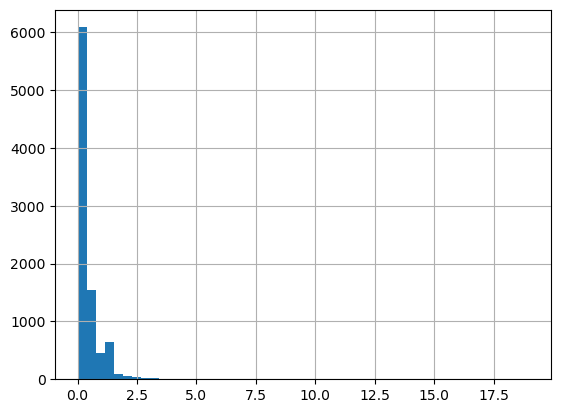

In [226]:
zscores['zscore'].abs().hist(bins = 50)

# Plot

In [285]:
add = [
    ['psychiatric', 'psychiatrist', 1],
    ['firearm', 'gun', 1],
    ['guns', 'gun', 1],
    ['vet', 'veterans', 1],
    ['veteran', 'veterans', 1],
    ['ptsd survivors of america', 'ptsd', 1],
    ['doctor', 'dr', 1],
    ['dem', 'democrat', 1],
    ['psych', 'psychiatric', 1],
    ['serve', 'service', 1],
    # ['psych', 'psychiatric', 1],
    ['psych', 'psychologist', 1],
    ['psychologist', 'psychiatrist', 1],
    
    ['live', 'life', 1],
    
    
    
    
]
add = pd.DataFrame(add, columns=most_similar_df.columns )
most_similar_df = pd.concat([most_similar_df,add], axis=0)
most_similar_df = most_similar_df.drop_duplicates()
most_similar_df = most_similar_df.reset_index(drop=True).sort_values('cos')
most_similar_df

,theme_a,theme_b,cos
0,june,september,0.65
96,vehicle,ford,0.65
97,trump,hillary clinton,0.65
98,dod civilian,servicemen,0.65
99,route,journey,0.65
...,...,...,...
9998,veteran,veterans,1.00
9996,vet,veterans,1.00
10012,live,life,1.00
10003,serve,service,1.00


In [272]:
zscores_d = dict(zip(zscores['token'], zscores['zscore']))

In [273]:

def improve_text_position(x):
    """ it is more efficient if the x values are sorted """
    # fix indentation 
    positions = ['top center', 'bottom center']  # you can add more: left center ...
    return [positions[i % len(positions)] for i in range(len(x))]

In [274]:
zscores

,token,zscore,count,label,annotation_names
0,humor,-5.435197,421,Suicidal,humor
1,officer,-2.891886,145,Suicidal,officer
2,uniform,-2.554653,96,Suicidal,uniform
3,crime,-2.489028,91,Suicidal,crime
4,military career,-2.372766,81,Suicidal,military career
...,...,...,...,...,...
8956,help,6.567728,102,Suicidal,help
8957,depression,9.918703,321,Suicidal,depression
8958,ptsd,10.438213,939,Suicidal,ptsd
8959,suicidal,12.202538,234,Suicidal,suicidal


In [275]:
counts_df['odds_ratio'].values * (-1)

array([-0.        , -0.31549428, -0.4390608 , ..., -0.80841839,
       -0.65102725, -0.        ])

In [276]:
group_name

'SITB Absent'

In [277]:
'Absent' in group_name

True

In [278]:
group_names

['SITB Present', 'SITB Absent']

In [279]:
tags_or_themes_d.keys()

dict_keys(['SITB Present', 'SITB Absent'])

In [280]:
zscores.iloc[:30]

,token,zscore,count,label,annotation_names
0,humor,-5.435197,421,Suicidal,humor
1,officer,-2.891886,145,Suicidal,officer
2,uniform,-2.554653,96,Suicidal,uniform
3,crime,-2.489028,91,Suicidal,crime
4,military career,-2.372766,81,Suicidal,military career
5,leadership,-2.322241,170,Suicidal,leadership
6,law,-2.158926,73,Suicidal,law
7,terrorism,-2.136666,65,Suicidal,terrorism
8,pay,-2.117233,71,Suicidal,pay
9,service,-2.045044,261,Suicidal,service


In [302]:
zscores.iloc[-12:][::-1]

,token,zscore,count,label,annotation_names
8960,suicide,18.974024,792,Suicidal,suicide
8959,suicidal,12.202538,234,Suicidal,suicidal
8958,ptsd,10.438213,939,Suicidal,ptsd
8957,depression,9.918703,321,Suicidal,depression
8956,help,6.567728,102,Suicidal,help
8955,mental,5.750742,138,Suicidal,mental
8954,mental health,5.732957,214,Suicidal,mental health
8953,depressed,5.324511,86,Suicidal,depressed
8952,suffer,5.191562,124,Suicidal,suffer
8951,live,4.910552,114,Suicidal,live


In [288]:
# %%time 
# ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')
# min_count_to_include_umap = 2
# display_text_threshold = 5
# display_text_threshold_odds_ratio_absent = 1.7
# display_text_threshold_odds_ratio_present = 3
# size_by = 'odds_ratio'

# # for tags_or_themes_d, tags_or_themes_d_name in zip([tags_clean_all, themes_clean_all],['tags','themes']):
# for tags_or_themes_d, tags_or_themes_d_name in zip([tags_kws_clean_all],['themes']):
#     for group_name in group_names:
#         tags_clean_i = tags_or_themes_d.get(group_name)
#         # tags_clean_i = tags_clean_all.get(group_name)

#         # Distribution of tags
#         counts = Counter(tags_clean_i)
#         counts = dict(sorted(counts.items(), key=lambda item: item[1]))

#         # merge counts    
#         counts = merge_counts_by_similarity(counts, 
#                                             most_similar_df, 
#                                             cutoff = 0.8, 
#                                             do_not_merge= ['coast guard', 'marines', 'navy', 'army', 'air force',], # so that army is not merged with "air force".
#                                             display_word='shortest',
#                                             display_word_exceptions=['depression', 'air force', 'rallypoint', 'veterans'],    # show this if available
#                                             verbose = False)

#         counts_df = pd.DataFrame(counts, index = ['count']).T
#         counts_df = counts_df.reset_index()
#         counts_df.columns = [tags_col, 'count']
#         # remove themes with just 1 occurrance
#         counts_df = counts_df[counts_df['count']>=min_count_to_include_umap]
#         counts_tags = counts_df[tags_col].values

#         # how many multi-word tags are there?
#         word_counts = pd.DataFrame(Counter([len(n.split()) for n in counts_tags]), index=['counts']).T.reset_index()
#         word_counts.columns = ['words', 'N']
#         word_counts = word_counts.sort_values('words')
#         word_counts['Prop'] = (word_counts['N']/word_counts['N'].sum()).round(3)
#         display(word_counts)

#         # get embedding
#         # keep_original = ['2nd amendment', 'election 2016','election 2020', '2d lt','wo1', 'da form 4187', '2lt','25th id', 'n09n ncis', 'uh 60 pilot', '4th of july', 'article 15']
#         # counts_tags = [re.sub("\d", "#", n) if n not in keep_original else n for n in counts_tags] 
#         emb_cols = [n  for n in embeddings_df.columns if 'emb_' in n]
#         # embeddings_group = embeddings_df[embeddings_df['themes'].isin(counts_tags)][emb_cols]
#         embeddings_group = []
#         remove_themes = []
#         for tag in counts_tags:
#             emb = embeddings_df[embeddings_df['themes'] == tag][emb_cols]
#             if emb.shape[0]==0:
#                 remove_themes.append(tag)
#             embeddings_group.append(emb)
#         print(remove_themes)  
#         embeddings_group = pd.concat(embeddings_group)  
#         embeddings_group.columns = emb_cols
#         counts_df = counts_df[~counts_df[tags_col].isin(remove_themes)]

#         # vectorize(counts_tags, model_name = model_name, embedding_type = 'sentence')
#         # counts_df[embeddings_cols] = embeddings


        
#         # UMAP 
#         fit = umap.UMAP(n_neighbors = 15, n_components=2, metric = 'cosine',min_dist=0.1)
#         embeddings_2d = fit.fit_transform(embeddings_group)
#         # plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
#         # plt.title('UMAP embedding of random colours');
#         counts_df[['UMAP 1', 'UMAP 2']] = embeddings_2d

#         #
#         if group_name=='SITB Absent':
#             display_text_threshold=100
#         elif group_name=='SITB Present':
#             display_text_threshold=11


#         # add OR
#         counts_df['odds_ratio'] = counts_df['tags_lemmatized'].map(zscores_d)
#         if 'Absent' in group_name:
#             counts_df['odds_ratio'] = counts_df['odds_ratio'].values * (-1)
#             text_threshold = display_text_threshold_odds_ratio_absent
#         else:
#             text_threshold = display_text_threshold_odds_ratio_present
            

#         counts_df['odds_ratio'] = [n if n>=0 else 0 for n in counts_df['odds_ratio'].values]
#         counts_df['odds_ratio'] = [n if str(n)!='nan' else 0 for n in counts_df['odds_ratio'].values]

#         if size_by == 'odds_ratio':
#             # todo: top 40
#             counts_d = dict(zip(counts_df[tags_col].values, counts_df['odds_ratio'].values))
#             text_col = []
#             for k,v in counts_d.items():
#                 if v>text_threshold:
#                     text_col.append(k)
#                 else:
#                     text_col.append('')
#             counts_df['text'] = text_col
#         elif size_by == 'count':
#             # todo: top 40
#             counts_d = dict(zip(counts_df[tags_col].values, counts_df['count'].values))
#             text_col = []
#             for k,v in counts_d.items():
#                 if v>display_text_threshold:
#                     text_col.append(k)
#                 else:
#                     text_col.append('')
#             counts_df['text'] = text_col





#         import plotly.express as px
#         # df = px.data.iris() # iris is a pandas DataFrame
#         # counts_df['count_larger'] = counts_df['count'] *2
#         fig = px.scatter(counts_df, 
#                          x="UMAP 1", y="UMAP 2", 
#                          hover_name=tags_col,
#                          # color = ,
#                          text='text',
#                          size = 'odds_ratio', 
#                          opacity=0.6,
#                          title = group_name)

#         fig.update_layout(
#             autosize=False,
#             width=800,
#             height=700)




#         # fig.update_traces(textposition=improve_text_position(counts_df["UMAP 1"]))

#         # fig.update_traces(textposition='inside', textfont_size=8)

#         fig.update_layout(
#             font=dict(
#               # family="Courier New, monospace",
#               size=10,  # Set the font size here
#               # color="RebeccaPurple"
#           )
#         )



#         savefig = False
#         for template in ["simple_white",]:  #"plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
#             fig.update_layout(template=template,)# title="'%s' theme" % template)
#             if savefig:
#                 # save all files in the same html 
#                 with open(output_dir+f'themes_{tags_or_themes_d_name}_{group_name}_{ts}.html', 'a') as f:
#                     f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
#                 # save each file separately 
#                 # pio.write_image(fig,output_dir+f"themes_{group_name}_{ts}.png", scale=3, width=600, height=1200, engine='auto')
#                 # fig.write_html(output_dir+f"submissions_{activity}.html")
#             fig.show()
#     #     if emb.shape[0]==0:
#     #         remove_themes.append(tag)


# PLot all together and color code and highlight highest and lowest Odds ratio

# WARNING: many hacks done. Need to compute Odds ratio on merged terms, right now i'm just displaying one of the terms 

In [308]:
group_names

['SITB Present', 'SITB Absent']

,words,N,Prop
0,1,478,0.909
2,2,29,0.055
1,3,13,0.025
3,4,5,0.010
4,5,1,0.002


,words,N,Prop
0,1,3233,0.891
1,2,273,0.075
2,3,80,0.022
3,4,25,0.007
6,5,10,0.003
4,6,5,0.001
7,7,1,0.000
5,8,1,0.000


['50', '22', '800', '2000', '1877', '1881', '67', '46', '1923', '1820', '1853', '1862', '29', '60', '1965', '101st', '1964', '1979', '90', 'e5', '1976', '1966', '1977', '11b', '21', '400', '1969', '1967', 'm16', '1921', '1920', '1927', '1997', '1933', '1954', '1955', '556', '1915', '800', '80', '112', '1775', '1970', '2019', '1975', '1974', 's1', '2nd', '2011', '2007', '26', '38', '1876', '2020', '36', '15', '1962', '4187', 're3', '1861', '1864', '1946', '214', 'e4', '17', '1838', '55', '70', '40', '25', '14', '1963', '1863', '357', '22', '1941', '1942', 'ww2', '1943', '30', '19', '1865', '100', '50', '20', '18', '1945', '1944']


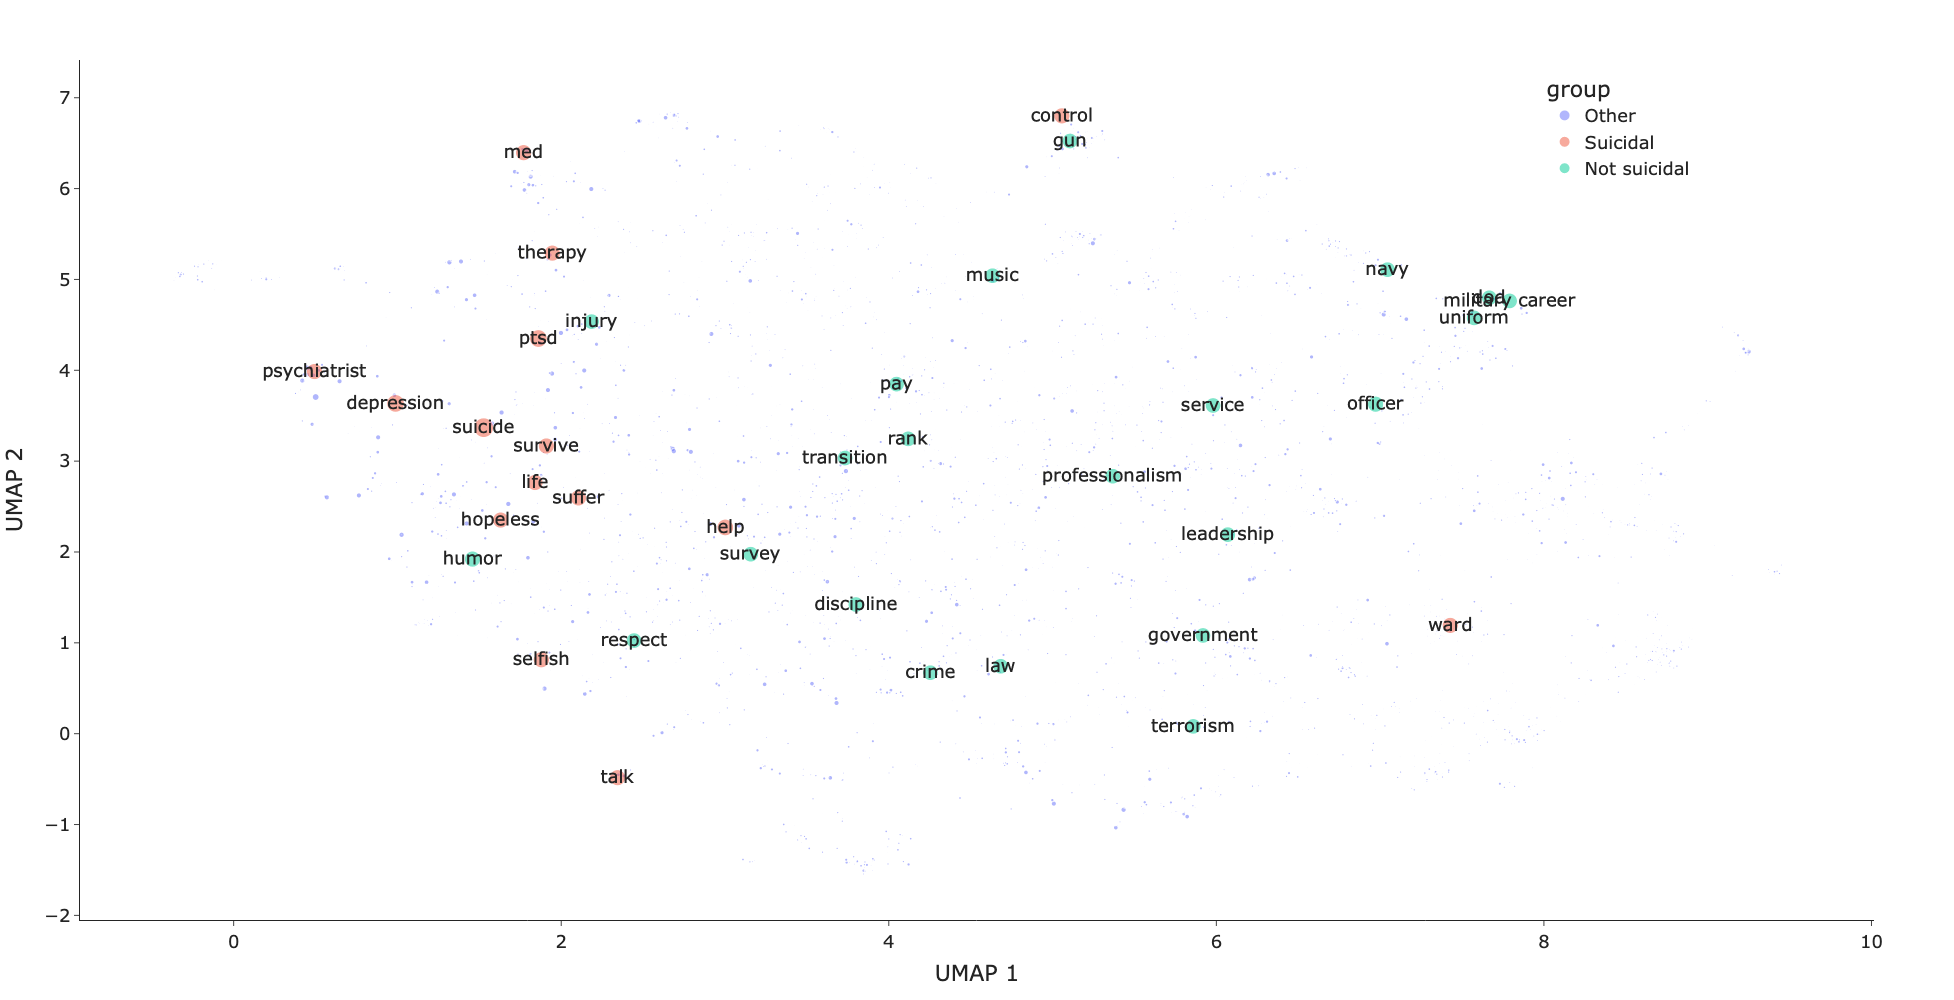

CPU times: user 37 s, sys: 1.58 s, total: 38.6 s
Wall time: 33.3 s


In [314]:
%%time 

counts_df_all = []
# embeddings_group_all = []

ts = datetime.datetime.utcnow().strftime('%y-%m-%dT%H-%M-%S')
min_count_to_include_umap = 2
display_text_threshold = 5
display_text_threshold_odds_ratio_absent = 1.7
display_text_threshold_odds_ratio_present = 3.5
size_by = 'odds_ratio'

make_circles_bigger = True

# for tags_or_themes_d, tags_or_themes_d_name in zip([tags_clean_all, themes_clean_all],['tags','themes']):
for tags_or_themes_d, tags_or_themes_d_name in zip([tags_kws_clean_all],['themes']):
    for group_name in group_names:
        tags_clean_i = tags_or_themes_d.get(group_name)
        # tags_clean_i = tags_clean_all.get(group_name)

        # Distribution of tags
        counts = Counter(tags_clean_i)
        counts = dict(sorted(counts.items(), key=lambda item: item[1]))

        # merge counts    
        counts = merge_counts_by_similarity(counts, 
                                            most_similar_df, 
                                            cutoff = 0.8, 
                                            do_not_merge= ['coast guard', 'marines', 'navy', 'army', 'air force',], # so that army is not merged with "air force".
                                            display_word='shortest',
                                            display_word_exceptions=['depression', 'air force', 'rallypoint', 'veterans'],    # show this if available
                                            verbose = False)

        counts_df = pd.DataFrame(counts, index = ['count']).T
        counts_df = counts_df.reset_index()
        counts_df.columns = [tags_col, 'count']
        # remove themes with just 1 occurrance
        counts_df = counts_df[counts_df['count']>=min_count_to_include_umap]
        counts_tags = counts_df[tags_col].values

        # how many multi-word tags are there?
        word_counts = pd.DataFrame(Counter([len(n.split()) for n in counts_tags]), index=['counts']).T.reset_index()
        word_counts.columns = ['words', 'N']
        word_counts = word_counts.sort_values('words')
        word_counts['Prop'] = (word_counts['N']/word_counts['N'].sum()).round(3)
        display(word_counts)



        # vectorize(counts_tags, model_name = model_name, embedding_type = 'sentence')
        # counts_df[embeddings_cols] = embeddings
        
        
        
        
        #
        if group_name=='SITB Absent':
            display_text_threshold=100
        elif group_name=='SITB Present':
            display_text_threshold=11

        # add OR
        counts_df['odds_ratio'] = counts_df['tags_lemmatized'].map(zscores_d)
        if 'Absent' in group_name:
            counts_df['odds_ratio'] = counts_df['odds_ratio'].values * (-1)
            text_threshold = display_text_threshold_odds_ratio_absent
        
        else:
            text_threshold = display_text_threshold_odds_ratio_present
            
        counts_df['odds_ratio'] = [n if n>=0 else 0 for n in counts_df['odds_ratio'].values]
        counts_df['odds_ratio'] = [n if str(n)!='nan' else 0 for n in counts_df['odds_ratio'].values]
        
        
        
        
        if group_name == 'SITB Present':
            counts_df['group'] = ['Suicidal' for n in range(counts_df.shape[0])]
        else:
            counts_df['group'] = ['Not suicidal' for n in range(counts_df.shape[0])]


        if size_by == 'odds_ratio':
            # todo: top 40
            counts_d = dict(zip(counts_df[tags_col].values, counts_df['odds_ratio'].values))
            text_col = []
            for k,v in counts_d.items():
                if k in ['psych', 'psychologist', 'mental', 'civilian career', 'leader']:
                    text_col.append('')
                    
                elif v>text_threshold:
                    text_col.append(k)
                else:
                    text_col.append('')
            counts_df['text'] = text_col
        elif size_by == 'count':
            # todo: top 40
            counts_d = dict(zip(counts_df[tags_col].values, counts_df['count'].values))
            text_col = []
            for k,v in counts_d.items():
                if v>display_text_threshold:
                    text_col.append(k)
                else:
                    text_col.append('')
            counts_df['text'] = text_col
        counts_df_all.append(counts_df)

        
counts_df_all = pd.concat(counts_df_all)
# embeddings_group_all = pd.concat(embeddings_group_all)
counts_df_all


# get embedding
counts_tags = counts_df_all[tags_col].values

# keep_original = ['2nd amendment', 'election 2016','election 2020', '2d lt','wo1', 'da form 4187', '2lt','25th id', 'n09n ncis', 'uh 60 pilot', '4th of july', 'article 15']
# counts_tags = [re.sub("\d", "#", n) if n not in keep_original else n for n in counts_tags] 
emb_cols = [n  for n in embeddings_df.columns if 'emb_' in n]
# embeddings_group = embeddings_df[embeddings_df['themes'].isin(counts_tags)][emb_cols]
embeddings_group = []
remove_themes = []
for tag in counts_tags:
    emb = embeddings_df[embeddings_df['themes'] == tag][emb_cols]
    if emb.shape[0]==0:
        remove_themes.append(tag)
    embeddings_group.append(emb)
print(remove_themes)  
embeddings_group = pd.concat(embeddings_group)  
embeddings_group.columns = emb_cols
counts_df_all = counts_df_all[~counts_df_all[tags_col].isin(remove_themes)]


# UMAP 
fit = umap.UMAP(n_neighbors = 15, n_components=2, metric = 'cosine',min_dist=0.1)
embeddings_2d = fit.fit_transform(embeddings_group)
# plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
# plt.title('UMAP embedding of random colours');
counts_df_all[['UMAP 1', 'UMAP 2']] = embeddings_2d


group_new = []
for group,text  in zip(counts_df_all['group'].values, counts_df_all['text'].values):
    if text!='':
        group_new.append(group)
    else:
        group_new.append('Other')
        
counts_df_all['group'] = group_new


import plotly.express as px
# df = px.data.iris() # iris is a pandas DataFrame
# counts_df_all['count_larger'] = counts_df_all['count'] *2

if make_circles_bigger:
    counts_df_all['odds_ratio'] = [n+5**2 if t!='' else n for n, t in zip(counts_df_all['odds_ratio'].values,counts_df_all['text'].values)]

fig = px.scatter(counts_df_all, 
                 x="UMAP 1", y="UMAP 2", 
                 hover_name=tags_col,
                 color = 'group',
                 text='text',
                 size = 'odds_ratio', 
                 opacity=0.5,
                 title = '')



width = 1200
height = 1000

fig.update_layout(
    autosize=False,
    width=width,
    height=height)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.90
))




# fig.update_traces(textposition=improve_text_position(counts_df_all["UMAP 1"]))

# fig.update_traces(textposition='inside', textfont_size=8)

fig.update_layout(
    font=dict(
      # family="Courier New, monospace",
      size=18,  # Set the font size here
      # color="RebeccaPurple"
  )
)



savefig = True
for template in ["simple_white",]:  #"plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
    fig.update_layout(template=template,)# title="'%s' theme" % template)
    if savefig:
        # save all files in the same html 
        with open(output_dir+f'themes_{tags_or_themes_d_name}_{group_name}_{ts}.html', 'a') as f:
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
        # save each file separately 
        pio.write_image(fig,output_dir+f"themes_all_{ts}.png", scale=3, width=width, height=height, engine='auto')
        # fig.write_html(output_dir+f"submissions_{activity}.html")
    fig.show()
#     if emb.shape[0]==0:
#         remove_themes.append(tag)




In [258]:
counts_df_all.tags_lemmatized.unique().shape

(3603,)

/var/folders/6f/x95fldf13xn_k25tybdzgtqw0000gn/T/ipykernel_27578/1759195774.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tags_lemmatized,count,odds_ratio,group,text,UMAP 1,UMAP 2,group_new
0,sexual,4,1.439858,SITB Present,,2.701942,0.036840,Other
24,soldier,53,0.000000,SITB Present,,8.248658,3.346198,Other
25,basic combat traine,2,0.299724,SITB Present,,6.905563,3.719613,Other
26,symptom,15,3.164846,SITB Present,symptom,2.380828,5.597235,SITB Present
28,pet,8,2.353963,SITB Present,,7.465168,5.539061,Other
...,...,...,...,...,...,...,...,...
7427,die,156,0.000000,SITB Absent,,2.498788,2.613575,Other
7428,disability,159,0.000000,SITB Absent,,9.852970,2.210431,Other
7429,inspiration,167,0.808418,SITB Absent,,4.167505,2.308875,Other
7430,family,177,0.651027,SITB Absent,,2.575248,-1.457543,Other


In [ ]:
Compute topics, Then ask what the likelihood of using topic_i_words in absent vs present

Compute likelihood of using words in absent vs present, then cluster into topics. 


In [62]:
counts_df[counts_df['text']!=''].sort_values('count').iloc[:30]

,tags_lemmatized,count,UMAP 1,UMAP 2,text
1141,firearm,101,3.504155,7.669831,firearm
95,uniform,102,5.905398,6.032971,uniform
4023,valor,102,4.979563,6.043640,valor
655,guns,103,3.459713,7.601830,guns
1689,disabled veteran,104,7.196764,5.760640,disabled veteran
7376,democrats,105,4.874954,2.210171,democrats
7268,suffer,109,1.536272,4.229748,suffer
6702,pain,110,1.003622,5.483461,pain
7419,trump,112,5.606192,1.943641,trump
7420,office of the president,113,5.479756,2.168736,office of the president


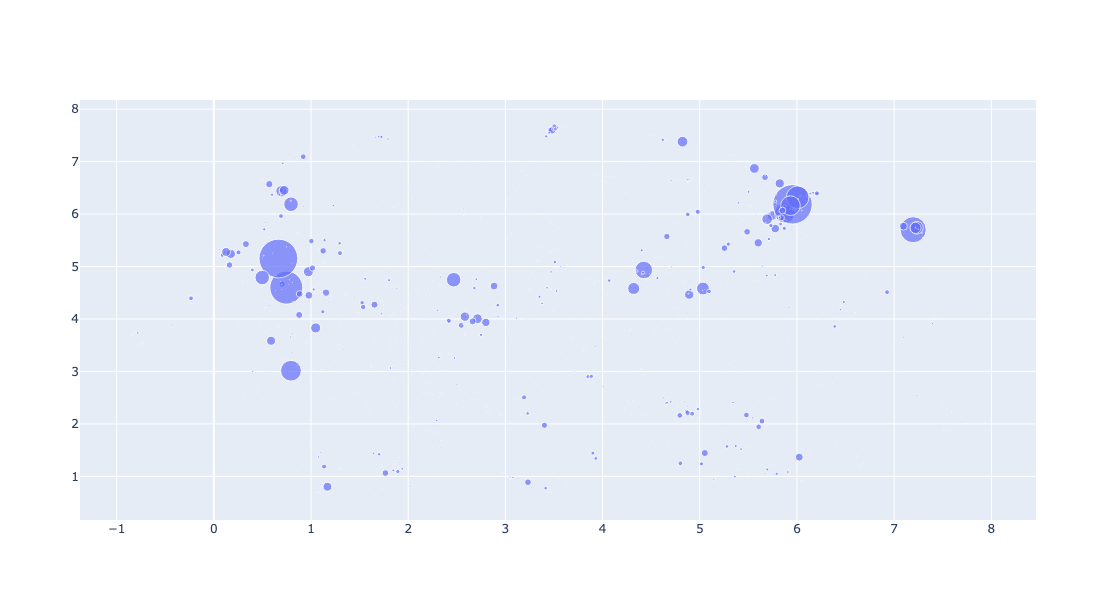

In [63]:
    # fig = px.scatter(counts_df, x="UMAP 1", y="UMAP 2", hover_name=tags_col,text='text',size = 'count', title = group_name)


import plotly.graph_objects as go

fig = go.Figure()

# Add traces

fig = go.Figure(data=go.Scatter(
    x=counts_df['UMAP 1'],
    y=counts_df['UMAP 2'],
    mode='markers',
    marker=dict(size=counts_df['count']/20,
                # color=[0, 1, 2, 3]
               ),
    text = counts_df['text'],
    textfont =dict(
        # family="Courier New, monospace",
        size=20,
        color="black"
    ),
    # hover_name=counts_df[tags_col],
))

fig.update_traces(textposition='middle center')

fig.update_layout(
autosize=False,
width=900,
height=600,)




# for x_i, y_i in zip(counts_df['UMAP 1'].values, counts_df['UMAP 2'].values):
#     fig.add_trace(go.Scatter(x=[x_i], y=[y_i],
#                         mode='markers',
#                         name='markers'))

fig.show()

In [64]:
# fig = px.scatter(counts_df, x="UMAP 1", y="UMAP 2", hover_name=tags_col,text='text',size = 'count', title = group_name)

# basic plot
sns.regplot(data=counts_df, x="UMAP 1", y="UMAP 2", fit_reg=False, marker="o", color="skyblue", 
            size = 'count'
            # scatter_kws={'s':400}
           )
 
# add annotations one by one with a loop
# for line in range(0,df.shape[0]):
#      plt.text(df.x[line]+0.2, df.y[line], df.group[line], horizontalalignment='left', size='medium', color='black', weight='semibold')

plt.show()

TypeError: regplot() got an unexpected keyword argument 'size'

In [ ]:
spacy_lemmatizer(['depression depressive suicidal suicide'])

# merge with metadata, branches of military and segment that way

# TODO
- merge similar words with exceptions
- top 40 instead of above threshold
- word size proportional to count


# I can cluster similar words to color code to obtain topics. 

# Try Top2Vec which clusters similar words, and then I can label clusters

# Do network of words